# Figure 3

This notebook must be run within the `benchmark_env` environment.

In [32]:
library(tidyverse)
library(ggplot2)
library(purrr)

In [33]:
lib_names <- c("KEGG_2021_Human", 
               "Reactome_2022", 
               "WikiPathway_2023_Human")
df_list <- list()
for (lib in lib_names) {
  file_path <- paste0("outputs/gsai_vs_llm2geneset_outputs_", lib, ".tsv")
  df_cur <- readr::read_tsv(file_path)
  df_cur$source <- lib
  df_list[[lib]] <- df_cur
}

df <- bind_rows(df_list)

df_list_ora <- list()
for (lib in lib_names) {
  file_path <- paste0("outputs/ora_outputs_", lib, ".tsv")
  df_cur <- readr::read_tsv(file_path)
  df_cur$source <- lib
  df_list_ora[[lib]] <- df_cur
}
df_ora <- bind_rows(df_list_ora)

df <- bind_rows(df, df_ora)

df <- df %>%
  mutate(library = case_when(
    library == "KEGG_2021_Human" ~ "KEGG",
    library == "Reactome_2022" ~ "Reactome",
    library == "WikiPathway_2023_Human" ~ "WikiPathways",
    TRUE ~ library  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

df <- df %>%
  mutate(method = case_when(
    method == "ORA" ~ "ORA(GOBP)",
    TRUE ~ method  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))


Rows: 1920 Columns: 11
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): model, library, gt_name, gt_name_clean, name, method
dbl (5): ROUGE1, ROUGE2, csim, in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10908 Columns: 11
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): model, library, gt_name, gt_name_clean, name, method
dbl (5): ROUGE1, ROUGE2, csim, in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4806 Columns: 11
── Column specif

In [34]:
table(df$method)
df$method <- factor(df$method, levels=c("llm2geneset","GSAI", "ORA(GOBP)"))


       GSAI llm2geneset   ORA(GOBP) 
       8817        8817        8817 

In [4]:
# Assuming df is your data frame
result <- df %>% 
  filter(method %in% c("llm2geneset", "GSAI")) %>%
  mutate(method = factor(method, levels = c("llm2geneset", "GSAI"))) %>%  # Ensure factor order
  group_by(model, library) %>%         # Group by model and library
  nest() %>%                           # Nest the data for each group
  mutate(t_test = map(data, ~ t.test(csim ~ method, data = .x, alternative="greater"))) %>% # Apply t-test
  mutate(p_value = map_dbl(t_test, "p.value")) # Extract p-value

colnames(result)
result %>% select(c("model", "library", "p_value")) %>% arrange(model)

[1] "model"   "library" "data"    "t_test"  "p_value"

model,library,p_value
<fct>,<chr>,<dbl>
GPT-3.5,KEGG,2.348342e-11
GPT-3.5,Reactome,8.340432e-08
GPT-3.5,WikiPathways,1.196212e-05
GPT-4o mini,KEGG,4.947790e-10
GPT-4o mini,Reactome,3.447175e-11
GPT-4o mini,WikiPathways,4.229774e-11
GPT-4o,KEGG,3.426590e-14
GPT-4o,Reactome,7.466113e-28
GPT-4o,WikiPathways,3.316849e-09


In [5]:
colnames(df)

[1] "model"         "library"       "gt_name"       "gt_name_clean"
 [5] "name"          "ROUGE1"        "ROUGE2"        "csim"         
 [9] "method"        "in_toks"       "out_toks"      "source"

In [6]:
standard_error <- function(x) {
  sd(x, na.rm = TRUE) / sqrt(sum(!is.na(x)))
}

df_summary <- df %>%
  group_by(model, method, library) %>%
  summarize(
    mean_ROUGE1 = mean(ROUGE1, na.rm = TRUE),       # Compute mean of ROUGE1
    se_ROUGE1 = standard_error(ROUGE1),             # Compute standard error for ROUGE1

    mean_ROUGE2 = mean(ROUGE2, na.rm = TRUE),       # Compute mean of ROUGE2
    se_ROUGE2 = standard_error(ROUGE2),             # Compute standard error for ROUGE2

    mean_csim = mean(csim, na.rm = TRUE),           # Compute mean of csim
    se_csim = standard_error(csim),                 # Compute standard error for csim

    in_toks = sum(in_toks, na.rm = TRUE),           # Sum of in_toks
    out_toks = sum(out_toks, na.rm = TRUE)          # Sum of out_toks
  ) %>%
  ungroup()  # Ungroup the data

# View the summarized data frame
head(df_summary)

`summarise()` has grouped output by 'model', 'method'. You can override using the `.groups` argument.


model,method,library,mean_ROUGE1,se_ROUGE1,mean_ROUGE2,se_ROUGE2,mean_csim,se_csim,in_toks,out_toks
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GPT-3.5,llm2geneset,KEGG,0.4543006,0.023859851,0.33247768,0.024714429,0.6233366,0.016400470,459593,385875
GPT-3.5,llm2geneset,Reactome,0.2342751,0.006512147,0.09140654,0.005421183,0.5304419,0.004789555,2284765,2238745
GPT-3.5,llm2geneset,WikiPathways,0.2715906,0.010358633,0.13350146,0.009416301,0.5327091,0.007562813,937731,908727
GPT-3.5,GSAI,KEGG,0.3065365,0.019962813,0.13786458,0.017890612,0.4873091,0.011929632,454514,72062
GPT-3.5,GSAI,Reactome,0.2039449,0.005765270,0.04947202,0.004059041,0.4993828,0.003483819,2260439,442550
GPT-3.5,GSAI,WikiPathways,0.2398407,0.009716945,0.09114756,0.008261453,0.4914126,0.006145610,923864,194961


In [7]:
df_long <- df_summary %>%
  pivot_longer(cols = c(mean_ROUGE1, mean_ROUGE2, mean_csim),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "mean_value")  %>% # New column for the mean values
   select(c("model", "method", "library", "metric", "mean_value"))

df_long_se <- df_summary %>%
  pivot_longer(cols = c(se_ROUGE1, se_ROUGE2, se_csim),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "se") %>%  # New column for the mean values
  select(c("model", "method", "library", "metric", "se"))
# View the transformed data frame


df_long <- df_long %>%
  mutate(metric = case_when(
    metric == "mean_csim" ~ "Cosine Similarity",
    metric == "mean_ROUGE1" ~ "Shared Unigrams",
    metric == "mean_ROUGE2" ~ "Shared Bigrams",
    TRUE ~ metric  # Leave other values unchanged
  ))

df_long_se <- df_long_se %>%
  mutate(metric = case_when(
    metric == "se_csim" ~ "Cosine Similarity",
    metric == "se_ROUGE1" ~ "Shared Unigrams",
    metric == "se_ROUGE2" ~ "Shared Bigrams",
    TRUE ~ metric  # Leave other values unchanged
  ))

df_long <- df_long %>% left_join(df_long_se)
df_long <- df_long %>%
  mutate(metric = factor(metric, levels = c("Shared Unigrams", "Shared Bigrams", 
                                            "Cosine Similarity")))

head(df_long)
head(df_long_se)

Joining with `by = join_by(model, method, library, metric)`


model,method,library,metric,mean_value,se
<fct>,<fct>,<chr>,<fct>,<dbl>,<dbl>
GPT-3.5,llm2geneset,KEGG,Shared Unigrams,0.45430060,0.023859851
GPT-3.5,llm2geneset,KEGG,Shared Bigrams,0.33247768,0.024714429
GPT-3.5,llm2geneset,KEGG,Cosine Similarity,0.62333658,0.016400470
GPT-3.5,llm2geneset,Reactome,Shared Unigrams,0.23427512,0.006512147
GPT-3.5,llm2geneset,Reactome,Shared Bigrams,0.09140654,0.005421183
GPT-3.5,llm2geneset,Reactome,Cosine Similarity,0.53044186,0.004789555


model,method,library,metric,se
<fct>,<fct>,<chr>,<chr>,<dbl>
GPT-3.5,llm2geneset,KEGG,Shared Unigrams,0.023859851
GPT-3.5,llm2geneset,KEGG,Shared Bigrams,0.024714429
GPT-3.5,llm2geneset,KEGG,Cosine Similarity,0.016400470
GPT-3.5,llm2geneset,Reactome,Shared Unigrams,0.006512147
GPT-3.5,llm2geneset,Reactome,Shared Bigrams,0.005421183
GPT-3.5,llm2geneset,Reactome,Cosine Similarity,0.004789555


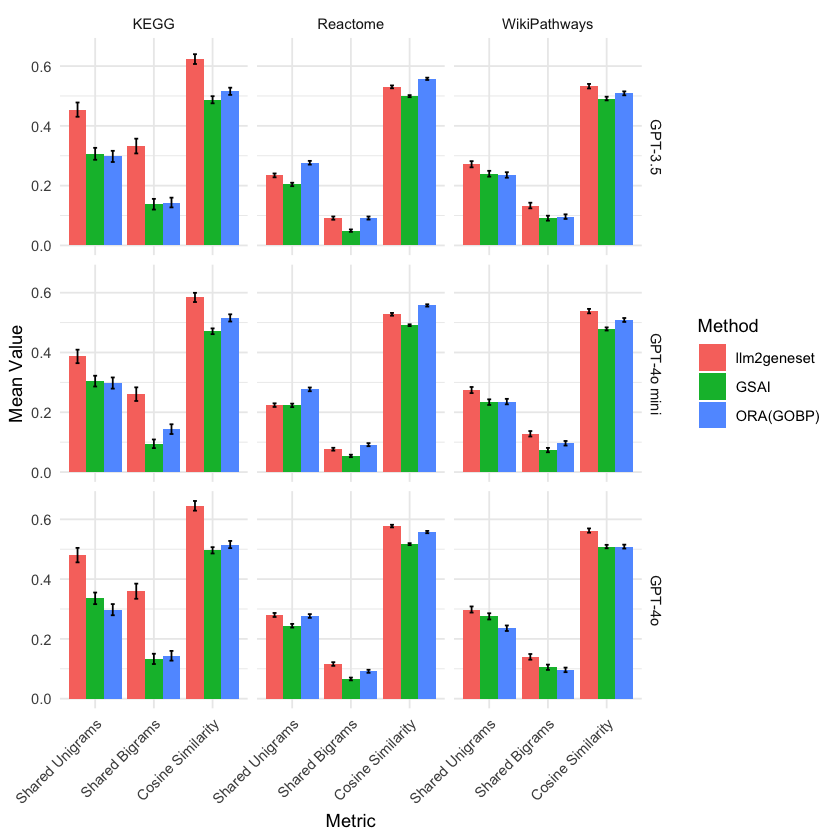

In [8]:

# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long, aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  geom_errorbar(aes(ymin = mean_value - se, ymax = mean_value + se), 
                width = 0.2,                    # Set width of error bars
                position = position_dodge(0.9)) +  # Position error bars to match bars
  facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [9]:
ggsave(p, file="figures/figS3A.pdf")

Saving 7 x 7 in image


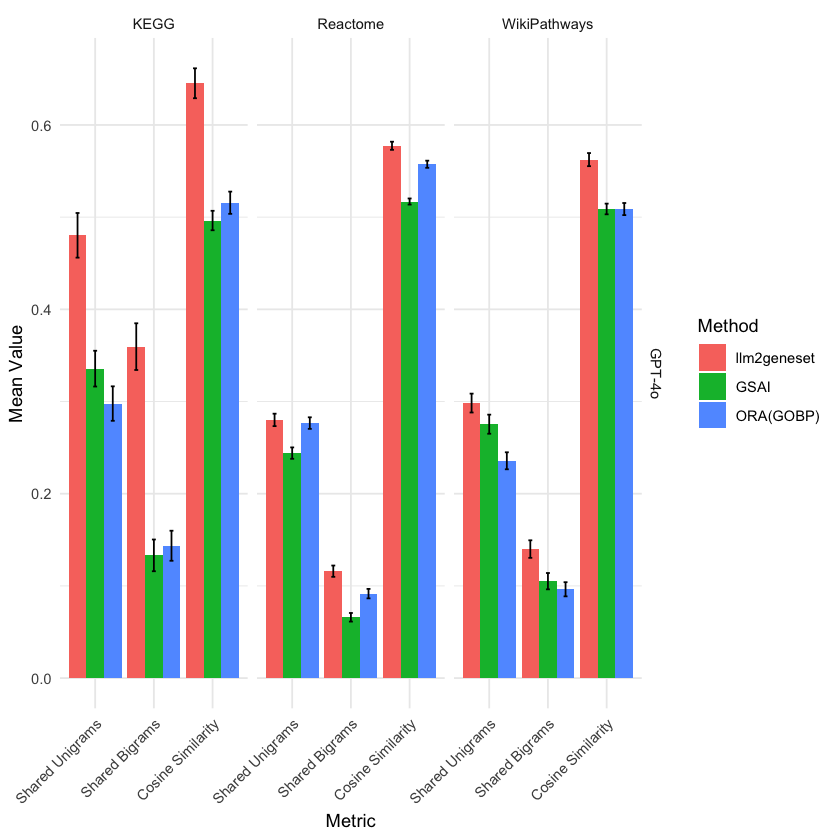

In [10]:

# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long %>% filter(model == "GPT-4o"), aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  geom_errorbar(aes(ymin = mean_value - se, ymax = mean_value + se), 
                width = 0.2,                    # Set width of error bars
                position = position_dodge(0.9)) +  # Position error bars to match bars
facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [12]:
ggsave(p, file="figures/fig3b.pdf", height=4.5)

Saving 7 x 4.5 in image


Saving 7 x 7 in image


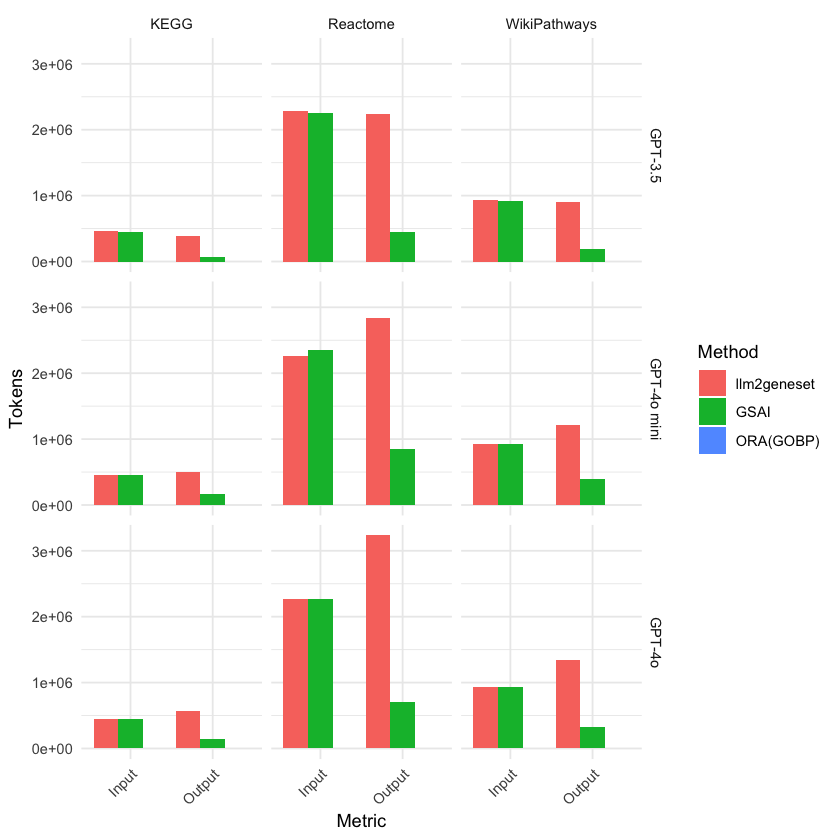

In [12]:
df_long <- df_summary %>%
  pivot_longer(cols = c(in_toks, out_toks),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "mean_value")  # New column for the mean values

df_long <- df_long %>%
  mutate(metric = case_when(
    metric == "in_toks" ~ "Input",
    metric == "out_toks" ~ "Output",
    TRUE ~ metric  # Leave other values unchanged
  ))

# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long, aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Tokens", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p
ggsave(p, file="figures/figS3b.pdf")

# Figure 3D

In [ ]:
df <- readr::read_tsv("outputs/mix_genesets_outputs.tsv")
df_ora <- readr::read_tsv("outputs/ora_mix_genesets_outputs.tsv")
df_prompt2 <- readr::read_tsv("outputs/prompt2_mix_genesets_output.tsv")

df <- bind_rows(df, df_ora, df_prompt2)

df <- df %>%
  mutate(library = case_when(
    library == "KEGG_2021_Human" ~ "KEGG",
    library == "Reactome_2022" ~ "Reactome",
    library == "WikiPathway_2023_Human" ~ "WikiPathways",
    TRUE ~ library  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))


df <- df %>%
  mutate(method = case_when(
    method == "ORA" ~ "ORA(GOBP)",
    method == "GSAI_2hint" ~ "GSAI(hint)",
    TRUE ~ method  # Leave other values unchanged
  ))

df$method <- factor(df$method, levels=c("llm2geneset","GSAI", "ORA(GOBP)", "GSAI(hint)"))


Rows: 900 Columns: 9
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): model, library, gt_name, gt_name_clean, name, method
dbl (3): ROUGE1, ROUGE2, csim

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 450 Columns: 9
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): model, library, gt_name, gt_name_clean, name, method
dbl (3): ROUGE1, ROUGE2, csim

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 450 Columns: 9
── Column specification ─────────────────────────────────────

In [67]:
standard_error <- function(x) {
  sd(x, na.rm = TRUE) / sqrt(sum(!is.na(x)))
}

df_summary <- df %>%
  group_by(model, method, library) %>%
  summarize(
    mean_ROUGE1 = mean(ROUGE1, na.rm = TRUE),       # Compute mean of ROUGE1
    se_ROUGE1 = standard_error(ROUGE1),             # Compute standard error for ROUGE1

    mean_ROUGE2 = mean(ROUGE2, na.rm = TRUE),       # Compute mean of ROUGE2
    se_ROUGE2 = standard_error(ROUGE2),             # Compute standard error for ROUGE2

    mean_csim = mean(csim, na.rm = TRUE),           # Compute mean of csim
    se_csim = standard_error(csim),                 # Compute standard error for csim
  ) %>%
  ungroup()  # Ungroup the data

# View the summarized data frame
head(df_summary)

`summarise()` has grouped output by 'model', 'method'. You can override using the `.groups` argument.


model,method,library,mean_ROUGE1,se_ROUGE1,mean_ROUGE2,se_ROUGE2,mean_csim,se_csim
<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GPT-3.5,llm2geneset,KEGG,0.6859841,0.03891343,0.46738095,0.04248087,0.7284601,0.01878321
GPT-3.5,llm2geneset,Reactome,0.4269931,0.03535010,0.23641814,0.03084106,0.6505657,0.02312064
GPT-3.5,llm2geneset,WikiPathways,0.5367503,0.03862892,0.27926263,0.03744892,0.6854255,0.01494829
GPT-3.5,GSAI,KEGG,0.3236746,0.02603746,0.14250000,0.02471636,0.5687956,0.01642715
GPT-3.5,GSAI,Reactome,0.2880574,0.02311467,0.09745405,0.01819633,0.5834309,0.01387131
GPT-3.5,GSAI,WikiPathways,0.3367198,0.02581819,0.15466667,0.02664729,0.6121961,0.01517211


Joining with `by = join_by(model, method, library, metric)`


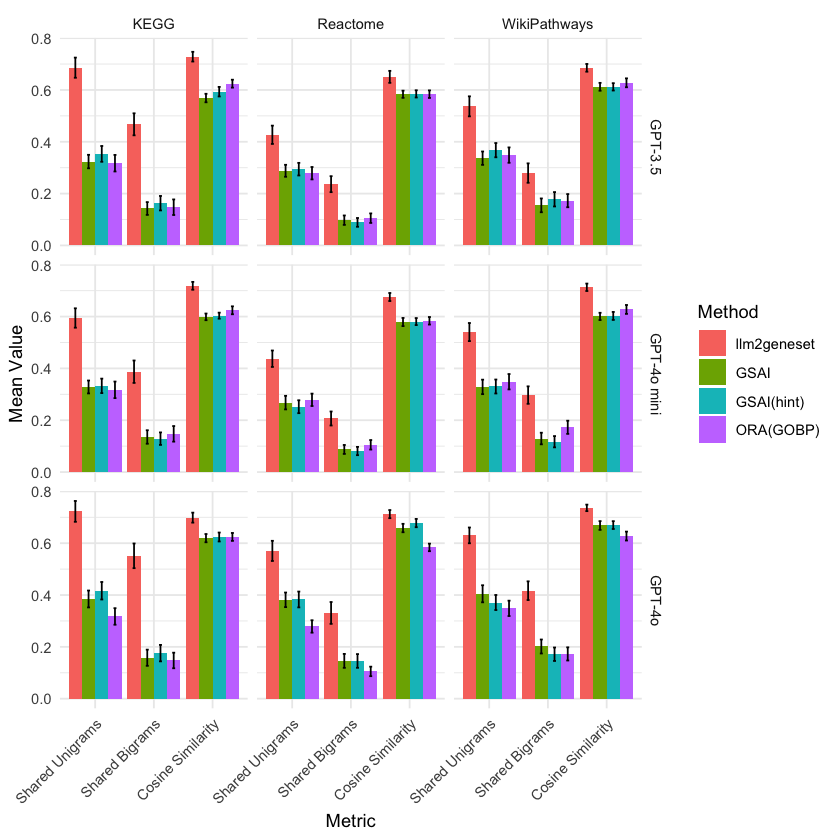

In [68]:
df_long <- df_summary %>%
  pivot_longer(cols = c(mean_ROUGE1, mean_ROUGE2, mean_csim),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "mean_value")  %>% # New column for the mean values
   select(c("model", "method", "library", "metric", "mean_value"))

df_long_se <- df_summary %>%
  pivot_longer(cols = c(se_ROUGE1, se_ROUGE2, se_csim),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "se") %>%  # New column for the mean values
  select(c("model", "method", "library", "metric", "se"))
# View the transformed data frame


df_long <- df_long %>%
  mutate(metric = case_when(
    metric == "mean_csim" ~ "Cosine Similarity",
    metric == "mean_ROUGE1" ~ "Shared Unigrams",
    metric == "mean_ROUGE2" ~ "Shared Bigrams",
    TRUE ~ metric  # Leave other values unchanged
  ))

df_long_se <- df_long_se %>%
  mutate(metric = case_when(
    metric == "se_csim" ~ "Cosine Similarity",
    metric == "se_ROUGE1" ~ "Shared Unigrams",
    metric == "se_ROUGE2" ~ "Shared Bigrams",
    TRUE ~ metric  # Leave other values unchanged
  ))

df_long <- df_long %>% left_join(df_long_se)
df_long <- df_long %>%
  mutate(metric = factor(metric, levels = c("Shared Unigrams", "Shared Bigrams", 
                                            "Cosine Similarity")))



# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long, aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  geom_errorbar(aes(ymin = mean_value - se, ymax = mean_value + se), 
                width = 0.2,                    # Set width of error bars
                position = position_dodge(0.9)) +  # Position error bars to match bars 
facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [69]:
ggsave(p, file='figures/figS3C.pdf')

Saving 7 x 7 in image


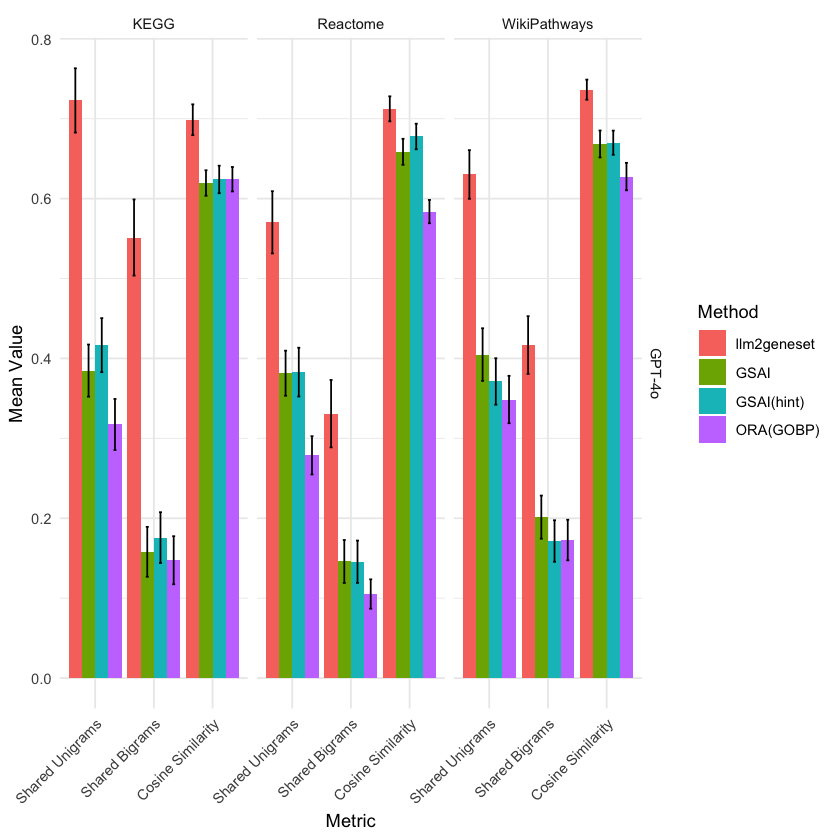

In [70]:
# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long %>% filter(model == "GPT-4o"), aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  geom_errorbar(aes(ymin = mean_value - se, ymax = mean_value + se), 
                width = 0.2,                    # Set width of error bars
                position = position_dodge(0.9)) +  # Position error bars to match bars
facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [71]:
ggsave(p, file="figures/fig3c.pdf", height=4.5)

Saving 7 x 4.5 in image
